In [1]:
%load_ext autoreload
%autoreload

In [2]:
from utils_v1 import *


In [3]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import sys
import numpy as np
from src.dataset import (
    MultipleDates,
    PAMultipleDates,
    MTMultipleDates,
    MAMultipleDates,
    MSMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.manager.multioutput import ManagerMCDropout, ManagerSingleRun, ManagerEnsemble
from src.Logger import Logger


c:\Users\jchamorro\anaconda3\envs\torch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ic.configureOutput(includeContext=True)

In [5]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [6]:
config = {
	"training": False,
	"inferring": True,
	"site": "PA",
	"training_date": "current", # values: earlier, current
	"mode": "single_run", # values: mcd, single_run, ensemble
	"uncertainty_method": "pred_entropy_single", # pred_var MI pred_entropy KL pred_entropy_single
	"loadInference": False,
	"removePolygons": True,
	"plotLandsat": False,
	"plotPOI": False,
 

	"save_probabilities": False,
	"addPastDeforestationInput": True,
	"classes_mode": False,
	"learning_rate": 1e-4,
    "use_cloud_mask": False,
    
	"General": {
		"device": "cuda",
		"model_type": "deeplab",
		"optim": "adam",
		"lr": 1e-4,
		"momentum": 0.9,
		"batch_size": 32,
		"epochs": 100,
		"input_bands": 21,
		"path_model": "models",
		"exp_id": 0
		
	},
    "Dataset": {
        "patch_size": 128,
        "class_n": 3,
		"transforms":{
            "resize":224,
            "p_flip":0.5,
            "p_crop":0.3,
            "p_rot":0.2
		}
  	},
	"Train": {
        "lr": 1e-4,
        "batch_size": 32,
        "epochs": 100,
        "input_bands": 21,
        "transforms": {
            "resize": 224
        }    
    }  
}

In [7]:



if config['mode'] == 'mcd':
	managerClass = ManagerMCDropout
	config['inference_times'] = 10
	config['training_times'] = 1
elif config['mode'] == 'single_run':
	managerClass = ManagerSingleRun
	config['inference_times'] = 1
	config['training_times'] = 1
	config['uncertainty_method'] = 'pred_entropy_single'
elif config['mode'] == 'ensemble':
	managerClass = ManagerEnsemble
	config['inference_times'] = 10
	config['training_times'] = 10
else:
	raise ValueError('Invalid mode')

print(config)

if config['site'] == 'PA':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]

	dataset = PAMultipleDates(config = config,
			   dates = dates, 
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif config['site'] == 'MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]

	dataset = MTMultipleDates(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif config['site'] == 'MS':
	dates = [2019, 2020]
	dataset = MSMultipleDates(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)		
else:
	raise ValueError('Invalid site')

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()



if config['training'] == False:

	if type(dataset) == PAMultipleDates:


		if config['training_date'] == 'current': exp = 10; repetition_id = 0
		elif config['training_date'] == 'earlier': exp = 1; repetition_id = 7
		 
	elif type(dataset) == MTMultipleDates:
		
		if config['training_date'] == 'current': exp = 2; repetition_id = 8
		elif config['training_date'] == 'earlier': exp = 3; repetition_id = 6		

	elif type(dataset) == MSMultipleDates:

		if config['training_date'] == 'current': exp = 0; repetition_id = 0
		elif config['training_date'] == 'earlier': exp = 1; repetition_id = 0		

else:

	exp = 10
	repetition_id = 0
	
logger = Logger()
manager = managerClass(config, dataset, patchesHandler, logger)
manager.defineExperiment(exp)


{'training': False, 'inferring': True, 'site': 'PA', 'training_date': 'current', 'mode': 'single_run', 'uncertainty_method': 'pred_entropy_single', 'loadInference': False, 'removePolygons': True, 'plotLandsat': False, 'plotPOI': False, 'save_probabilities': False, 'addPastDeforestationInput': True, 'classes_mode': False, 'learning_rate': 0.0001, 'use_cloud_mask': False, 'General': {'device': 'cuda', 'model_type': 'deeplab', 'optim': 'adam', 'lr': 0.0001, 'momentum': 0.9, 'batch_size': 32, 'epochs': 100, 'input_bands': 21, 'path_model': 'models', 'exp_id': 0}, 'Dataset': {'patch_size': 128, 'class_n': 3, 'transforms': {'resize': 224, 'p_flip': 0.5, 'p_crop': 0.3, 'p_rot': 0.2}}, 'Train': {'lr': 0.0001, 'batch_size': 32, 'epochs': 100, 'input_bands': 21, 'transforms': {'resize': 224}}, 'inference_times': 1, 'training_times': 1}


ic| dataset.py:337 in __init__()- list(self.date_ids): [0]
ic| dataset.py:358 in __init__()
    self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| patchesHandler.py:148 in __init__()- self.input_image_shape: 21
ic| patchesHandler.py:149 in __init__()
    self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [8]:
manager.config

{'training': False,
 'inferring': True,
 'site': 'PA',
 'training_date': 'current',
 'mode': 'single_run',
 'uncertainty_method': 'pred_entropy_single',
 'loadInference': False,
 'removePolygons': True,
 'plotLandsat': False,
 'plotPOI': False,
 'save_probabilities': False,
 'addPastDeforestationInput': True,
 'classes_mode': False,
 'learning_rate': 0.0001,
 'use_cloud_mask': False,
 'General': {'device': 'cuda',
  'model_type': 'deeplab',
  'optim': 'adam',
  'lr': 0.0001,
  'momentum': 0.9,
  'batch_size': 32,
  'epochs': 100,
  'input_bands': 21,
  'path_model': 'models',
  'exp_id': 0},
 'Dataset': {'patch_size': 128,
  'class_n': 3,
  'transforms': {'resize': 224, 'p_flip': 0.5, 'p_crop': 0.3, 'p_rot': 0.2}},
 'Train': {'lr': 0.0001,
  'batch_size': 32,
  'epochs': 100,
  'input_bands': 21,
  'transforms': {'resize': 224}},
 'inference_times': 1,
 'training_times': 1,
 'dropout_training': False}

In [9]:
exp

10

In [10]:
manager.setExperimentPath()
manager.createLogFolders()

In [11]:
# ic(type(dataset), exp, dataset.dates)


In [12]:

manager.loadLabel()

C:/Users/jchamorro/Documents/jorge/datasets/deforestation/PA/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:453 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| dataset.py:456 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:460 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
C:/Users/jchamorro/Documents/jorge/datasets/deforestation/PA/deforestation_before_2008_PA.tif


ic| dataset.py:464 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| dataset.py:466 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| dataset.py:445 in loadLabel()
    label_per_date.shape: (17730, 9203, 1)


Removing bufer................
Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [13]:

# Creating tile mask
manager.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [14]:

manager.label_mask.dtype

dtype('uint8')

In [15]:

manager.getLabelCurrentDeforestation()

In [16]:

manager.loadInputImage()

ic| dataset.py:387 in loadInputImage()
    image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [17]:

np.unique(manager.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

In [18]:
if config['site'] == 'MS':
    manager.maskNoDataAsNotConsideredClass()

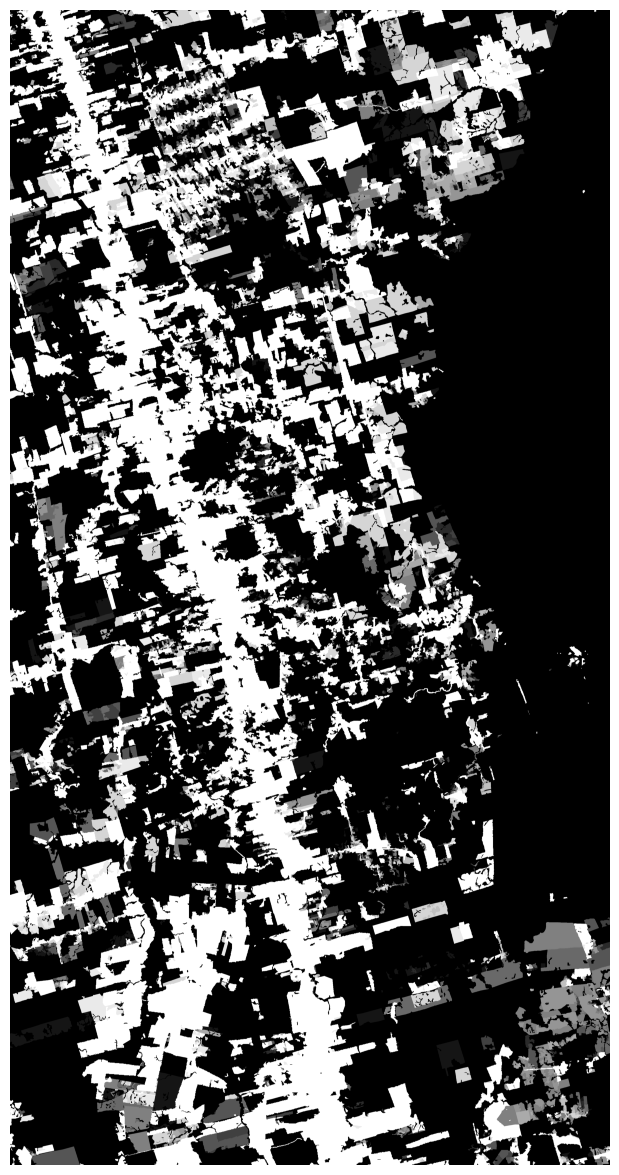

In [19]:

manager.logger.plotFigure(manager.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

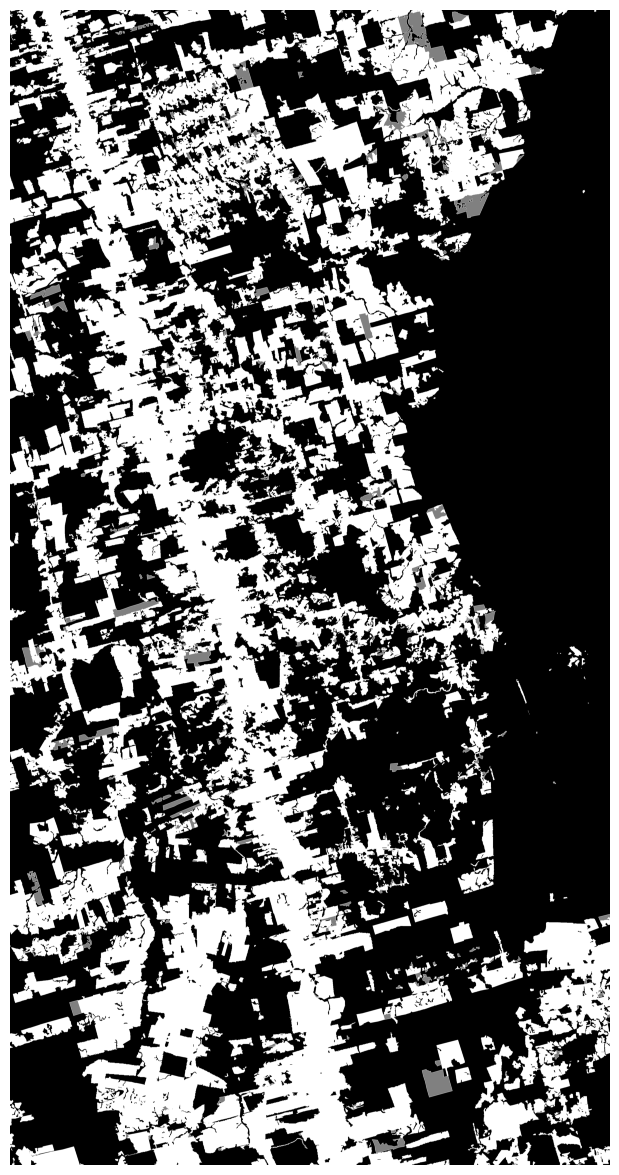

In [20]:

manager.logger.plotFigure(manager.label_mask, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [21]:

manager.getImageChannels()

ic| base.py:100 in getImageChannels()
    self.image_stack.shape: (17730, 9200, 21)
ic| base.py:102 in getImageChannels()- self.channels: 21


In [22]:

manager.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [23]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    manager.createIdxImage()


In [24]:
if config["training"] == True:
    manager.extractCoords()

In [25]:
if config["training"] == True:
    manager.trainTestSplit()

In [26]:
if config["training"] == True:
    manager.label_mask.shape

In [27]:
if config["training"] == True:

    manager.logger.plotFigure(manager.label_mask[...,-1], 
        name='Reference', cmap=plt.cm.gray, savefig=False)



In [28]:
if config["training"] == True:
    np.unique(manager.label_mask)

In [29]:
if config["training"] == True:
    print(manager.coords_train)

In [30]:
if config["training"] == True:
    manager.retrieveSamplesOfInterest()

In [31]:
if config["training"] == True:
    inputSnipShow = True

In [32]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [33]:
'''
count, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_amazon_ts == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [34]:
'''
count, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_tr_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [35]:
manager.dataset.image_channels

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]

In [36]:
manager.dataset.bands

10

In [37]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 1000)


In [38]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 97)


In [39]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 500)

In [40]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [41]:
if config["training"] == True:
    manager.getGenerators()


In [42]:
if config["training"] == True:
    manager.fixChannelNumber()

In [43]:
if config["training"] == True:
    print(manager.path_exp)

In [44]:
if config["training"] == True:
    print(manager.channels)

In [45]:
if config["training"] == True:
    print(manager.image_stack.shape)

In [46]:
if config["training"] == True:
    print("config['training_times']", config["training_times"])

In [47]:
if config["training"] == True:
    for tm in range(config['training_times']):
        manager.repetition_id = tm
        manager.train()

In [48]:
# if config["training"] == True:
#     manager.plotHistory()


In [49]:
repetition_id = 0

In [50]:
if config["inferring"] != True:
    sys.exit()
else:
    manager.repetition_id = repetition_id

In [51]:
manager.image_stack.shape

(17730, 9200, 21)

In [52]:
manager.patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [53]:
if issubclass(type(dataset), MultipleDates):
	manager.channels = manager.patchesHandler.input_image_shape
	manager.image_stack = manager.image_stack[..., manager.patchesHandler.dataset.image_channels[-1]]
	manager.label_mask = manager.label_mask[...,-1]


In [54]:
manager.image_stack.shape

(17730, 9200, 21)

In [55]:
manager.setPadding()

-30.0 -16.0


In [56]:
manager.infer()

device: cpu


ic| base.py:308 in infer()- path_model: 'models\\DeepLabV3Plus_0.pth'


Dropout training mode: False
time:  0
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 patch.shape (1, 3552, 2304, 21)
2 patch.shape torch.Size([1, 21, 3552, 2304])
1 

In [57]:
manager.loadPredictedProbabilities()

In [58]:
manager.prob_rec.shape

(17760, 9216, 1)

In [59]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [60]:
manager.prob_rec.shape

(17760, 9216, 1)

In [61]:
manager.getMeanProb()

In [62]:
manager.logger.getStats(manager.mean_prob)

ic| Logger.py:119 in getStats()
    np.min(value): -586.5133
    np.mean(value): 0.4697558
    np.max(value): 34.250843


In [63]:
ic(manager.mean_prob.shape)

ic| 3703776524.py:1 in <module>
    manager.mean_prob.shape: (17760, 9216)


(17760, 9216)

In [64]:
manager.unpadMeanProb()

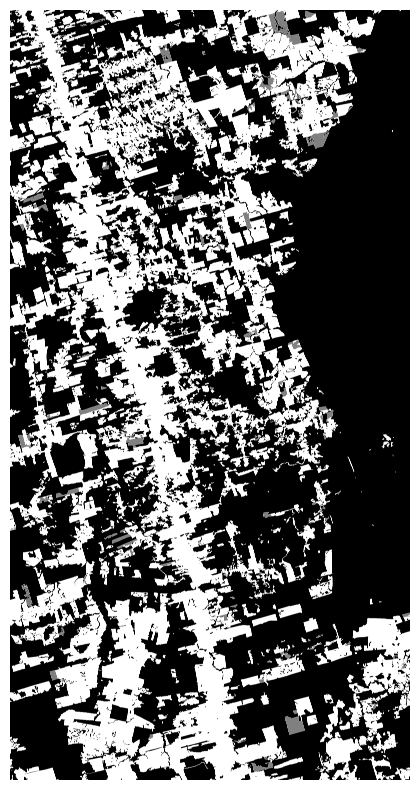

In [65]:
manager.logger.plotFigure(manager.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [66]:
manager.squeezeLabel()

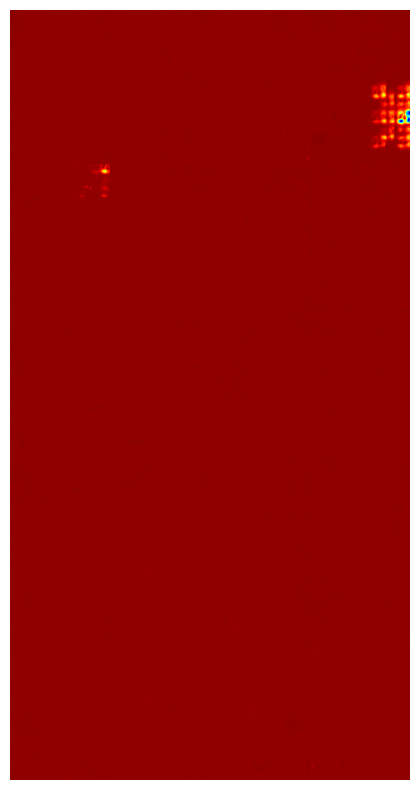

In [67]:
manager.setMeanProbNotConsideredAreas()
manager.logger.plotFigure(manager.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [68]:
print(manager.label_mask.shape)

(17730, 9200)


In [69]:
manager.getLabelTest()

(54840627,)
(array([0, 1], dtype=uint8), array([54073429,   767198], dtype=int64))


In [70]:
# manager.getMAP()

In [71]:
manager.prob_rec.shape

(17760, 9216, 1)

In [72]:
manager.preprocessProbRec()
print(manager.prob_rec.shape)

(1, 17760, 9216, 1)


In [73]:
manager.prob_rec.shape

(1, 17760, 9216, 1)

In [74]:
manager.logger.getStats(manager.prob_rec)

ic| Logger.py:119 in getStats()
    np.min(value): -586.5133
    np.mean(value): 0.4697558
    np.max(value): 34.250843


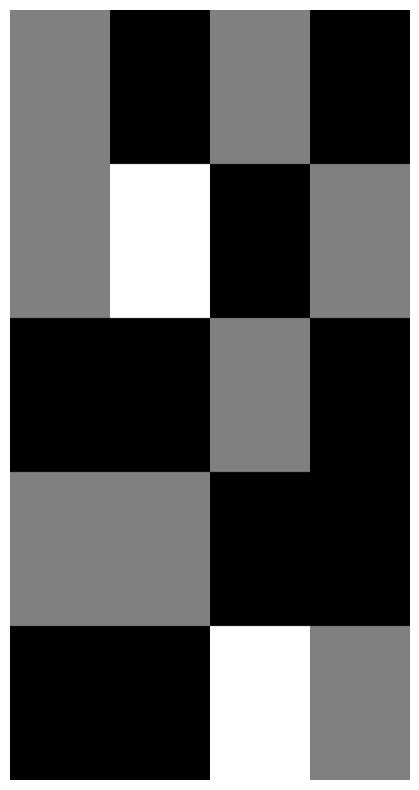

In [75]:
manager.logger.plotFigure(manager.mask_tr_val, 
            name=manager.dataset.site + manager.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [76]:
manager.getLabelCurrentDeforestation()

In [77]:
manager.applyProbabilityThreshold()

(17730, 9200)
Single entropy
(array([0., 1.], dtype=float32), array([ 58728903, 104387097], dtype=int64))


ic| base.py:434 in applyProbabilityThreshold()
    self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [78]:
manager.getTestValues()

ic| base.py:457 in getTestValues()- predicted_test.shape: (81558000,)
ic| base.py:466 in getTestValues()- predicted_test.shape: (54840627,)


In [79]:
manager.removeSmallPolygons()

ic| metrics.py:213 in removeSmallPolygonsForMetrics()
    np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([112601942,  50514058], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([117641602,  45474398], dtype=int64))
ic| metrics.py:215 in removeSmallPolygonsForMetrics()
    np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([158076340,   5039660], dtype=int64))


In [80]:
manager.calculateMetrics()

ic| base.py:510 in calculateMetrics()
    self.f1: 5.58
    self.precision: 2.87
    self.recall: 99.07


In [81]:
manager.getValidationValuesForMetrics()
manager.calculateMetricsValidation()

ic| base.py:439 in getValidationValuesForMetrics()
    self.label_mask_val.shape: (16311600,)
ic| base.py:445 in getValidationValuesForMetrics()
    self.label_mask_val_valid.shape: (8930005,)
ic| base.py:521 in calculateMetricsValidation()
    f1_val: 13.8
    precision_val: 7.42
    recall_val: 98.95
    mAP_val: 44.58


In [82]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    manager.calculateMAPWithoutSmallPolygons()

In [83]:
manager.get_label_no_buffer()

C:/Users/jchamorro/Documents/jorge/datasets/deforestation/PA/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:453 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| dataset.py:456 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:460 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
C:/Users/jchamorro/Documents/jorge/datasets/deforestation/PA/deforestation_before_2008_PA.tif


ic| dataset.py:464 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| dataset.py:466 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| dataset.py:445 in loadLabel()
    label_per_date.shape: (17730, 9203, 1)


In [84]:
manager.getErrorMask()

(array([0., 1.], dtype=float32), array([119299966,  43816034], dtype=int64))


In [85]:
manager.getErrorMaskToShowRGB()

[0. 1.]


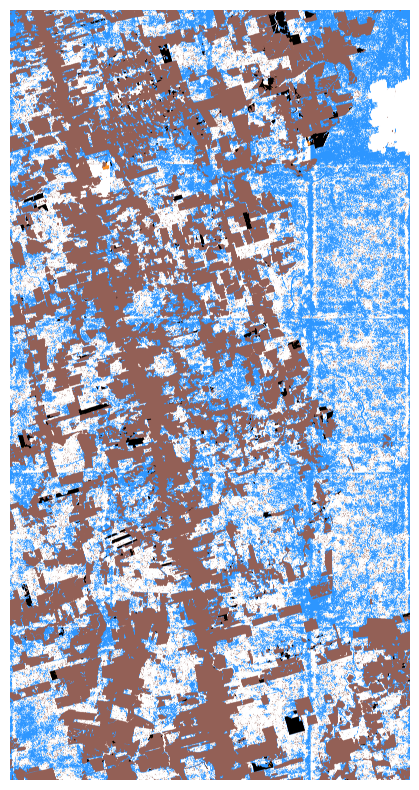

In [86]:
manager.logger.plotFigure(manager.error_mask_to_show_rgb[...,::-1], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [87]:
'''
import types

manager.setUncertainty = types.MethodType(setUncertainty, manager)
'''


'\nimport types\n\nmanager.setUncertainty = types.MethodType(setUncertainty, manager)\n'

In [88]:
manager.setUncertainty()

ic| uncertainty.py:49 in single_experiment_entropy()
    pred_entropy.

shape: (17760, 9216)
c:\Users\jchamorro\Documents\jorge\deforestation_uncertainty_torch\src\uncertainty.py:53: RuntimeWarning: invalid value encountered in log
  pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon)


In [89]:
manager.uncertainty_map[manager.uncertainty_map>1] = 1

In [90]:
manager.logger.getStats(manager.uncertainty_map)

ic| Logger.py:119 in getStats()
    np.min(value): nan
    np.mean(value): nan
    np.max(value): nan


In [91]:
manager.getUncertaintyToShow()
manager.logger.getStats(manager.uncertainty_to_show)


ic| Logger.py:119 in getStats()
    np.min(value): nan
    np.mean(value): nan
    np.max(value): nan


ic| 3944692317.py:4 in <module>
    manager.uncertainty_to_show.shape: (17730, 9200)


(17730, 9200)

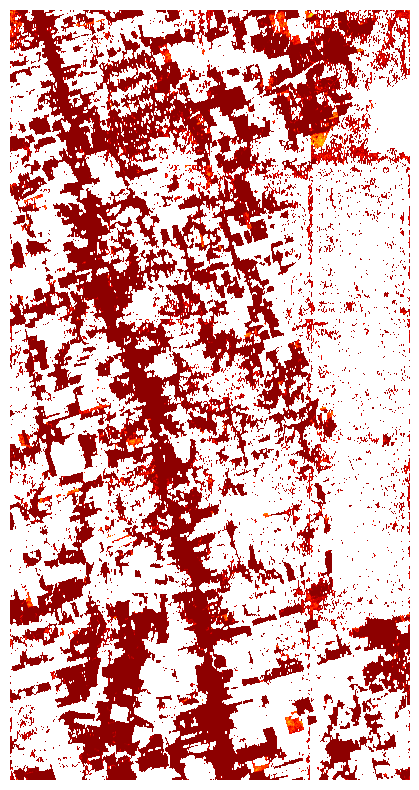

In [92]:

manager.logger.plotFigure(manager.uncertainty_to_show, 
            name=manager.dataset.site + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(manager.uncertainty_to_show.shape)



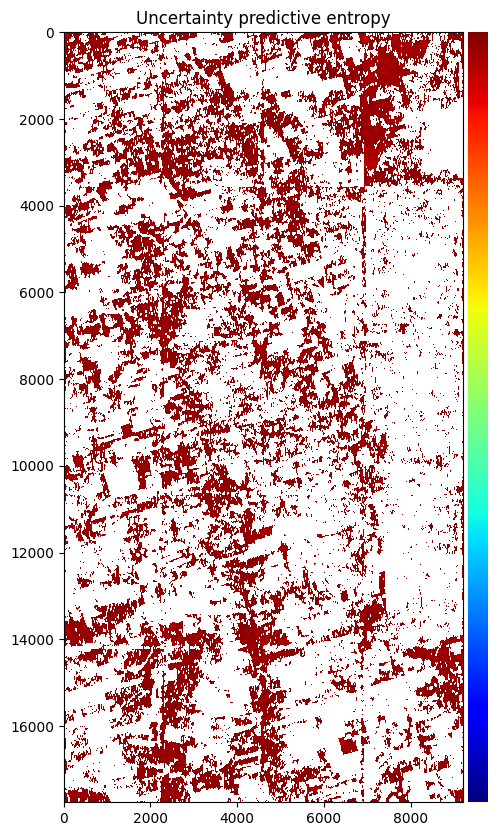

In [93]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

In [94]:
manager.getValidationValues2()
manager.getTestValues2()

ic| base.py:561 in getTestValues2()
    self.label_mask.shape: (17730, 9200)
ic| base.py:562 in getTestValues2()
    self.mask_amazon_ts.shape: (17730, 9200)
ic| base.py:566 in getTestValues2()
    self.label_mask_test.shape: (81558000,)
ic| base.py:574 in getTestValues2()
    self.error_mask_test.shape: (52392058,)


ic| Logger.py:163 in plotCropSample()
    manager.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    manager.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| Logger.py:165 in plotCropSample()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| Logger.py:167 in plotCropSample()
    np.unique(manager.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


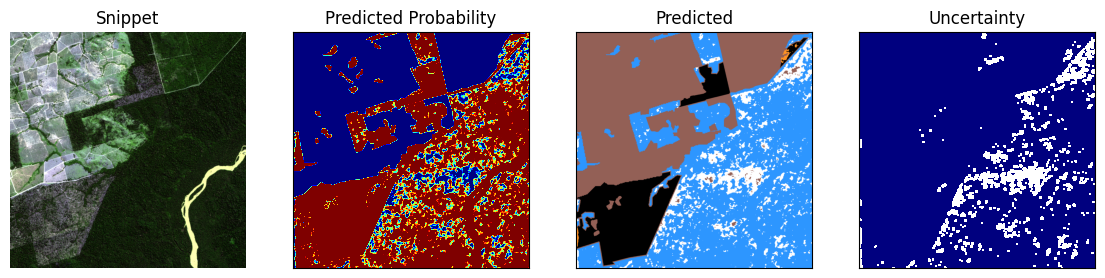

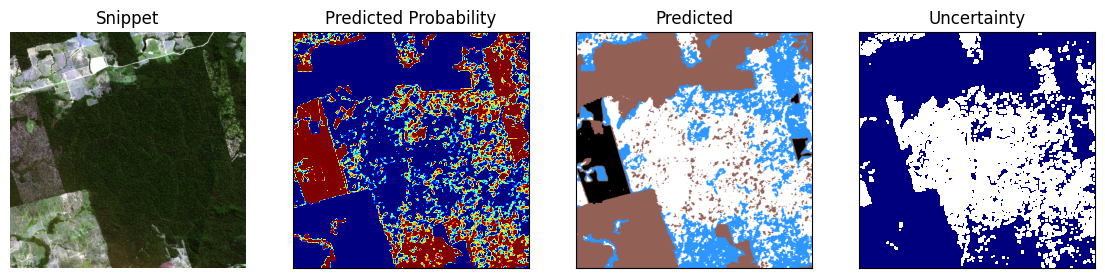

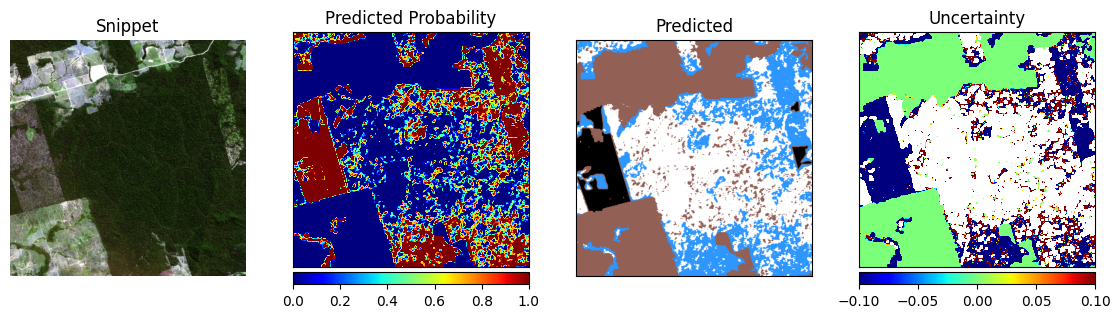

In [95]:
manager.logger.plotCropSample(manager)

In [96]:
if config["plotLandsat"] == True:
    label_tmp_dates = []
    for date in dataset.prodes_dates:
        label_tmp_date = dataset.loadLabelFromDate(date)
        label_tmp_date = label_tmp_date[:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1]]
        label_tmp_dates.append(label_tmp_date)

In [97]:
if config["plotLandsat"] == True:
    # del manager.image_stack
    import src.lansdatLoader as ll
    import importlib
    importlib.reload(ll)
    landsatLoader = ll.LandsatLoader(dataset)
    ims = landsatLoader.load()
    for idx in range(len(ims)):
        ims[idx] = ims[idx][:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1],:]
    ims = landsatLoader.darken_past_deforestation(ims, manager.label_no_buffer)
    ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])

In [98]:
if config["plotLandsat"] == True:
    logger.plotCropSampleLandsat(manager, ims)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


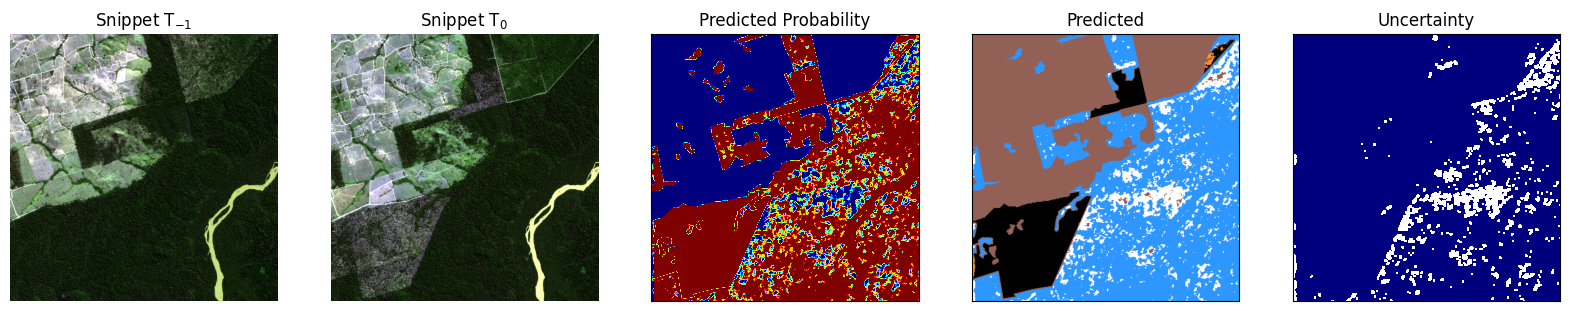

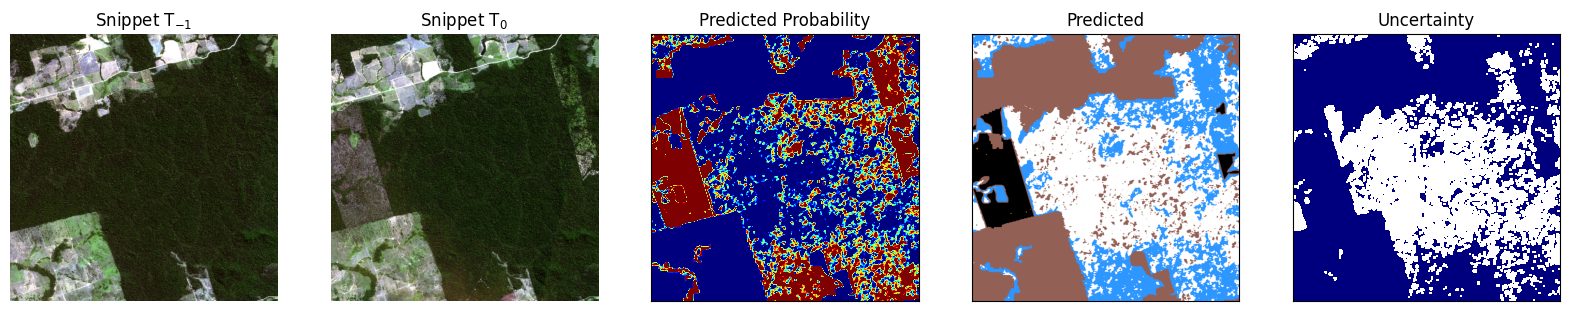

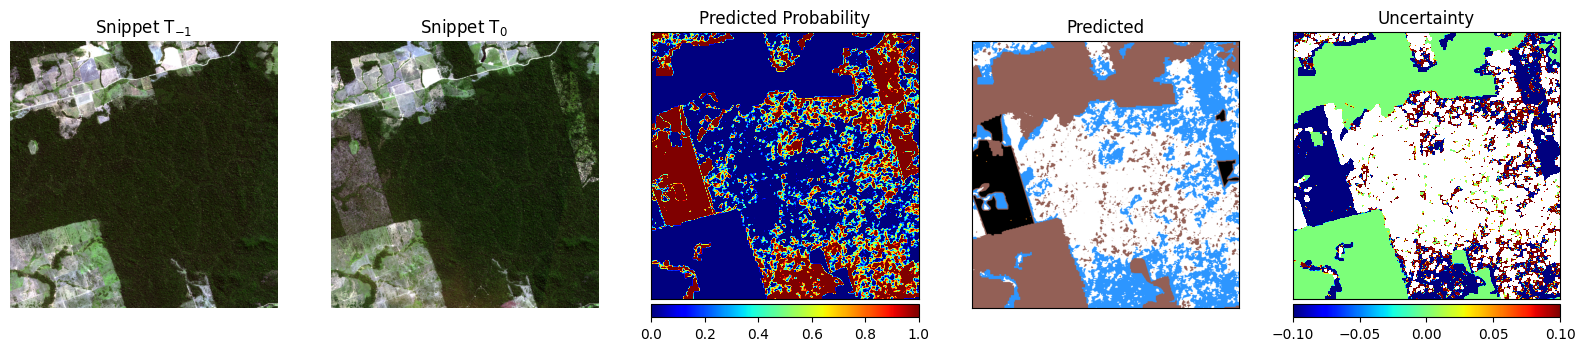

In [99]:
manager.logger.plotCropSampleT0T1(manager)

In [100]:
manager.logger.getStats(manager.uncertainty)


ic| Logger.py:119 in getStats()
    np.min(value): nan
    np.mean(value): nan
    np.max(value): nan


In [101]:
'''
manager.getOtherUncertaintyMetrics()
print(manager.sUEO)

print(manager.ece_score)  
'''

'\nmanager.getOtherUncertaintyMetrics()\nprint(manager.sUEO)\n\nprint(manager.ece_score)  \n'

In [102]:
if config["plotPOI"] == True and config['site'] == 'PA':

    print(manager.mean_prob.shape)
    font = {'family': "Times New Roman",
            'color':  'white',
            'weight': 'bold',
            'size': 24,
            }

    lims = dataset.previewLims1
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['A', 'B', 'C', 'D', 'E', 'F']

    for poi_id in range(4):
            
            plt.text(manager.dataset.snippet_coords['snippet_id0'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id0'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')

    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi0.png'), 
    dpi=150, bbox_inches='tight')

    lims = dataset.previewLims2
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['E', 'F']

    print(manager.dataset.snippet_coords['snippet_id1'])
    for poi_id in range(2):
            
            plt.text(manager.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')
            
    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi1.png'), 
    dpi=150, bbox_inches='tight')

In [103]:
if config["plotPOI"] == True and config['site'] == 'PA':
    manager.getPOIValues()


In [104]:

if config["plotPOI"] == True and config['site'] == 'PA':
    import pickle
    with open('output/log/log_ensemble_.pkl', 'wb') as f:
                pickle.dump(manager.snippet_poi_results, f)


In [105]:
from src import metrics as _metrics

def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy_single":
        self.threshold_list = [0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    if self.config['uncertainty_method'] == "pred_entropy":
            if self.classes_mode == False:
                    self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    # self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    #         0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            else:
                    self.threshold_list = [0.0025, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    
                    # self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    # 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [106]:

import types

manager.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, manager)



Get precision-recall threshold

In [107]:

manager.getUncertaintyAAValues()

ic| 810240186.py:62 in getUncertaintyAAValues()
    self.uncertainty.shape: (52392058,)
    self.label_mask_current_deforestation_test.shape: (52392058,)


[0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, nan, nan]
threshold 0.0075


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (20085365,)
    predicted_test_classified_incorrect.shape: (20085365,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 20085365
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 20085365
    len(label_mask_current_deforestation_test): 52392058


[0.04327805 0.99742942 0.97448766 0.3833666  0.00134779 0.7041256
 0.24598446]
threshold 0.01


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (20031793,)
    predicted_test_classified_incorrect.shape: (20031793,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 20031793
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 20031793
    len(label_mask_current_deforestation_test): 52392058


[0.0431679  0.99742697 0.9746112  0.38234408 0.00134426 0.70261128
 0.24481418]
threshold 0.015


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (19923152,)
    predicted_test_classified_incorrect.shape: (19923152,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 19923152
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 19923152
    len(label_mask_current_deforestation_test): 52392058


[0.04295024 0.99741931 0.97485963 0.38027046 0.00133692 0.69959786
 0.24249266]
threshold 0.025


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (19698795,)
    predicted_test_classified_incorrect.shape: (19698795,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 19698795
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 19698795
    len(label_mask_current_deforestation_test): 52392058


[0.0425154  0.99739988 0.97536735 0.37598819 0.00132127 0.69333825
 0.23779523]
threshold 0.05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (19102776,)
    predicted_test_classified_incorrect.shape: (19102776,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 19102776
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 19102776
    len(label_mask_current_deforestation_test): 52392058


[0.04143468 0.9973643  0.97654842 0.36461206 0.0012891  0.6772473
 0.2257995 ]
threshold 0.08


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (18325450,)
    predicted_test_classified_incorrect.shape: (18325450,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 18325450
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 18325450
    len(label_mask_current_deforestation_test): 52392058


[0.0401549  0.99730046 0.97796705 0.34977534 0.00124933 0.65595238
 0.21079371]
threshold 0.1


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (17770131,)
    predicted_test_classified_incorrect.shape: (17770131,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 17770131
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 17770131
    len(label_mask_current_deforestation_test): 52392058


[0.03931638 0.99723977 0.97896892 0.33917604 0.001216   0.63937463
 0.20039304]
threshold 0.15


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (16236890,)
    predicted_test_classified_incorrect.shape: (16236890,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 16236890
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 16236890
    len(label_mask_current_deforestation_test): 52392058


[0.03724158 0.99705628 0.9812333  0.30991128 0.00115447 0.59546621
 0.17258166]
threshold 0.2


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (14447182,)
    predicted_test_classified_incorrect.shape: (14447182,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 14447182
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 14447182
    len(label_mask_current_deforestation_test): 52392058


[0.03519046 0.99679687 0.98348818 0.27575137 0.00109253 0.53889171
 0.14136128]
threshold 0.225


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (13430124,)
    predicted_test_classified_incorrect.shape: (13430124,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 13430124
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 13430124
    len(label_mask_current_deforestation_test): 52392058


[0.03416572 0.99663752 0.98461223 0.25633893 0.00106237 0.50315032
 0.12403945]
threshold 0.25


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (12305218,)
    predicted_test_classified_incorrect.shape: (12305218,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 12305218
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 12305218
    len(label_mask_current_deforestation_test): 52392058


[0.03313173 0.99645124 0.98573899 0.234868   0.00103411 0.45990655
 0.10515654]
threshold 0.27


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (11307061,)
    predicted_test_classified_incorrect.shape: (11307061,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 11307061
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 11307061
    len(label_mask_current_deforestation_test): 52392058


[0.03229426 0.99623871 0.98665398 0.21581632 0.00101205 0.41879498
 0.08866621]
threshold 0.3


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (9578907,)
    predicted_test_classified_incorrect.shape: (9578907,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 9578907
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 9578907
    len(label_mask_current_deforestation_test): 52392058


[3.09924974e-02 9.95869216e-01 9.88068540e-01 1.82831280e-01
 9.85788977e-04 3.33795494e-01 6.04757087e-02]
threshold 0.34


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (6476147,)
    predicted_test_classified_incorrect.shape: (6476147,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6476147
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6476147
    len(label_mask_current_deforestation_test): 52392058


[2.90599589e-02 9.95066056e-01 9.90285410e-01 1.23609326e-01
 8.72470431e-04 8.27917491e-02 1.09806785e-02]
threshold 0.36


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (3524554,)
    predicted_test_classified_incorrect.shape: (3524554,)
c:\Users\jchamorro\Documents\jorge\deforestation_uncertainty_torch\src\metrics.py:296: RuntimeWarning: invalid value encountered in scalar divide
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3524554
    len(label_mask_current_deforestation_test): 52392058
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3524554
    len(label_mask_current_deforestation_test): 52392058


[2.86878326e-02 9.93128836e-01 9.90683171e-01 6.72726771e-02
            nan 0.00000000e+00 6.42400433e-05]
threshold nan


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| metrics.py:277 in getAA_Recall()
    np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| metrics.py:278 in getAA_Recall()
    np.all(predicted_test_classified_incorrect) == 0: False


[           nan            nan            nan 0.00000000e+00
            nan            nan 6.42400433e-05]
threshold nan


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (0,)
    predicted_test_classified_incorrect.shape: (0,)
ic| metrics.py:277 in getAA_Recall()
    np.all(label_current_deforestation_test_classified_incorrect) == 0: False
ic| metrics.py:278 in getAA_Recall()
    np.all(predicted_test_classified_incorrect) == 0: False


[           nan            nan            nan 0.00000000e+00
            nan            nan 6.42400433e-05]


In [108]:
manager.getUncertaintyAAAuditedValues()

ic| base.py:703 in getUncertaintyAAAuditedValues()
    self.uncertainty.shape: (52392058,)
    self.label_mask_current_deforestation_test.shape: (52392058,)


threshold 0.0075
(52392058,) (52392058,)
cm_audited [[35786772 15868662]
 [    1850   734774]]
[0.04425433 0.99748854]
threshold 0.01
(52392058,) (52392058,)
cm_audited [[35742435 15912999]
 [    1852   734772]]
[0.04413636 0.99748583]
threshold 0.015
(52392058,) (52392058,)
cm_audited [[35654074 16001360]
 [    1858   734766]]
[0.04390299 0.99747768]
threshold 0.025
(52392058,) (52392058,)
cm_audited [[35474647 16180787]
 [    1873   734751]]
[0.04343645 0.99745732]
threshold 0.05
(52392058,) (52392058,)
cm_audited [[35013747 16641687]
 [    1901   734723]]
[0.04228278 0.99741931]
threshold 0.08
(52392058,) (52392058,)
cm_audited [[34435450 17219984]
 [    1950   734674]]
[0.0409183  0.99735279]
threshold 0.1
(52392058,) (52392058,)
cm_audited [[34034795 17620639]
 [    1996   734628]]
[0.04002274 0.99729034]
threshold 0.15
(52392058,) (52392058,)
cm_audited [[32969821 18685613]
 [    2134   734490]]
[0.03782112 0.997103  ]
threshold 0.2
(52392058,) (52392058,)
cm_audited [[31793038 1

ic| base.py:709 in getUncertaintyAAAuditedValues()
    metric_values_audited: array([[0.04425433, 0.99748854],
                                  [0.04413636, 0.99748583],
                                  [0.04390299, 0.99747768],
                                  [0.04343645, 0.99745732],
                                  [0.04228278, 0.99741931],
                                  [0.0409183 , 0.99735279],
                                  [0.04002274, 0.99729034],
                                  [0.03782112, 0.997103  ],
                                  [0.03565116, 0.99683964],
                                  [0.03456993, 0.99667809],
                                  [0.03348097, 0.99648939],
                                  [0.0325989 , 0.9962749 ],
                                  [0.03123052, 0.99590157],
                                  [0.02919683, 0.99508976],
                                  [0.02875709, 0.99314576],
                                  [0.02868783, 0.

cm_audited [[26947198 24708236]
 [    6863   729761]]
[0.02868783 0.99068317]


In [109]:
manager.setPlotLimsForUncertaintyAA()

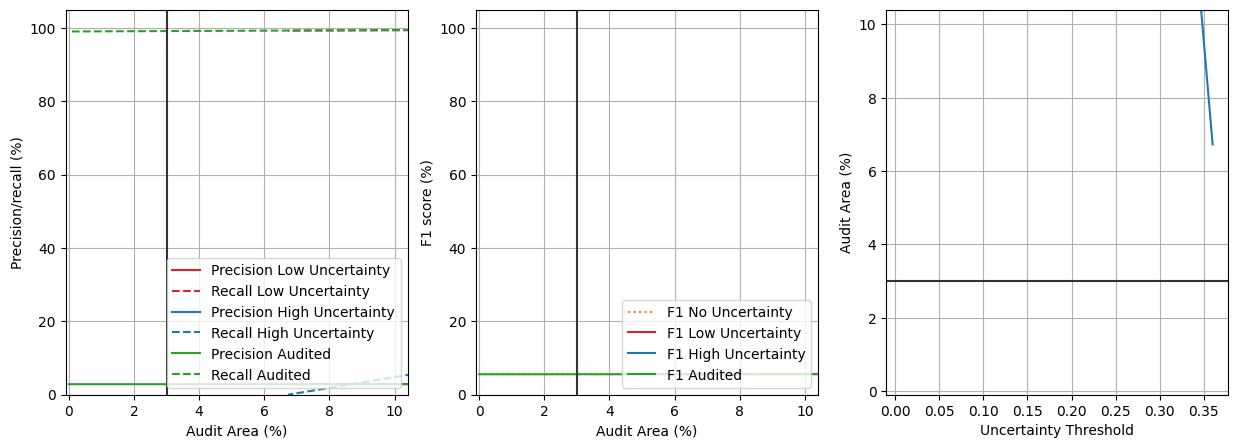

In [110]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
manager.plotUncertaintyAA(normalize_xlim=False)

In [111]:
manager.getOptimalUncertaintyThreshold(bound = 0.0015)

ic| base

.py:811 in getOptimalUncertaintyThreshold()
    bounds: (0.0015, nan)
c:\Users\jchamorro\anaconda3\envs\torch2\Lib\site-packages\scipy\optimize\_minimize.py:913: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


ValueError: Optimization bounds must be finite scalars.

In [ ]:
manager.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.1918446327132674


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1642142,)
    predicted_test_classified_incorrect.shape: (1642142,)
ic| metrics.py:300 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1642142
    len(label_mask_current_deforestation_test): 54734505
ic| metrics.py:302 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1642142
    len(label_mask_current_deforestation_test): 54734505


[0.97167169 0.94483046 0.59406689 0.03000195 0.7010088  0.55484451
 0.11057953]
threshold 0.1918446327132674
(54734505,) (54734505,)


ic| base.py:804 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_optimal: {'AA': array([0.03000195]),
                     'UEO': array([0.11057953]),
                     'f1': 83.98,
                     'f1_H': array([0.61942088]),
                     'f1_L': array([0.95806311]),
                     'precision_H': array([0.7010088]),
                     'precision_L': array([0.97167169]),
                     'recall_H': array([0.55484451]),
                     'recall_L': array([0.94483046]),
                     'recall_Ltotal': array([0.59406689])}
ic| base.py:805 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_audited_optimal: {'f1': array([0.97376836]),
                             'precision': array([0.98237432]),
                             'recall': array([0.96531187])}


cm_audited [[53987707    12714]
 [   25464   708620]]
[0.98237432 0.96531187]


{'metrics': {'precision_L': array([0.97167169]),
  'recall_L': array([0.94483046]),
  'recall_Ltotal': array([0.59406689]),
  'AA': array([0.03000195]),
  'precision_H': array([0.7010088]),
  'recall_H': array([0.55484451]),
  'UEO': array([0.11057953]),
  'f1_L': array([0.95806311]),
  'f1_H': array([0.61942088]),
  'f1': 83.98},
 'metrics_audited': {'precision': array([0.98237432]),
  'recall': array([0.96531187]),
  'f1': array([0.97376836])},
 'exp': 10}